In [2]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import cv2
from torchvision.transforms import transforms
from PIL import Image
import os

weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
model.eval() 

preprocess = weights.transforms()

def image_loader(image_name):
    if not os.path.exists(image_name):
        print(f"ERROR: File not found at path: {image_name}")
        return None
        
    image = Image.open(image_name).convert("RGB")
    return image

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

filename = 'glare_images/glare8keyboard.jpg'
image = cv2.imread(filename)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

In [4]:
def show_image(img, title):
    plt.imshow(img, cmap='gray')
    # plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_cv_image(cv_img, preprocess_func):

    if cv_img.ndim == 2:
        rgb_img = np.stack([cv_img, cv_img, cv_img], axis=2)
    else:
        rgb_img = cv_img

    pil_image = Image.fromarray(rgb_img)
    
    input_tensor = preprocess_func(pil_image)
    
    return input_tensor

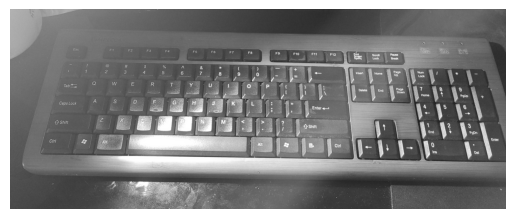

In [5]:
show_image(gray_image, "Original Grayscale Image")

In [6]:
# thresh_mean = cv2.adaptiveThreshold(
#     blurred, 255,
#     cv2.ADAPTIVE_THRESH_MEAN_C,
#     cv2.THRESH_BINARY,
#     199, 5
# )
# show_image(thresh_mean, "Adaptive Mean Thresholding")

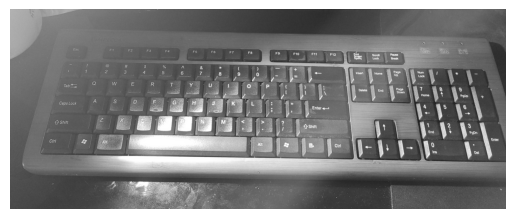

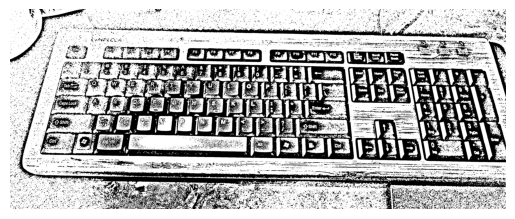

In [7]:
thresh_gauss = cv2.adaptiveThreshold(
    blurred, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    121, 3
)
show_image(gray_image, "Original Grayscale Image")
show_image(thresh_gauss, "Adaptive Gaussian Thresholding")

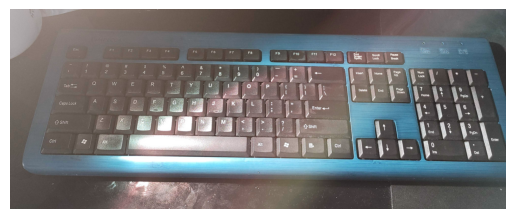

In [8]:
show_image(image, "Original Image")

In [9]:
input_tensor = preprocess_cv_image(gray_image, preprocess)
input_tensor_2 = preprocess_cv_image(thresh_gauss, preprocess)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_tensor.unsqueeze(0).to(device)
model.to(device)

with torch.no_grad():
    output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

predicted_index = torch.argmax(probabilities).item()

categories = weights.meta["categories"]
predicted_label = categories[predicted_index]
############# 
object_part_with_num = filename.split('glare')[1] 
object_part = object_part_with_num[1:]

expected_obj = object_part.split('.')[0]
print(f"File Name: {expected_obj}")
############
print("-" * 45)
print(f"Predicted Label: **{predicted_label}**")
print(f"Probability: {probabilities[predicted_index].item():.4f}")

print("Top 5 Predicted Categories:")
top5_prob, top5_indices = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    predicted_index = top5_indices[i].item()
    predicted_label = categories[predicted_index]
    probability = top5_prob[i].item()
    print(f"  {i+1}. **{predicted_label}** (Probability: {probability:.4f})")
print("-" * 45)
#------------------------------------------------------------#
input_batch = input_tensor_2.unsqueeze(0).to(device)
model.to(device)

with torch.no_grad():
    output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)

predicted_index = torch.argmax(probabilities).item()

categories = weights.meta["categories"]
predicted_label = categories[predicted_index]
print(f"Predicted Label: **{predicted_label}**")
# print(f"Probability: {probabilities[predicted_index].item():.4f}")

print("Top 5 Predicted Categories:")
top5_prob, top5_indices = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    predicted_index = top5_indices[i].item()
    predicted_label = categories[predicted_index]
    probability = top5_prob[i].item()
    print(f"  {i+1}. **{predicted_label}** (Probability: {probability:.4f})")
print("-" * 45)

File Name: images/
---------------------------------------------
Predicted Label: **computer keyboard**
Probability: 0.9207
Top 5 Predicted Categories:
  1. **computer keyboard** (Probability: 0.9207)
  2. **space bar** (Probability: 0.0608)
  3. **typewriter keyboard** (Probability: 0.0100)
  4. **notebook** (Probability: 0.0049)
  5. **mouse** (Probability: 0.0018)
---------------------------------------------
Predicted Label: **computer keyboard**
Top 5 Predicted Categories:
  1. **computer keyboard** (Probability: 0.4572)
  2. **typewriter keyboard** (Probability: 0.3417)
  3. **space bar** (Probability: 0.1580)
  4. **web site** (Probability: 0.0065)
  5. **crossword puzzle** (Probability: 0.0053)
---------------------------------------------
